In [1]:
import os
import sys
sys.path.insert(0, '/home/zzhuang/PseCo')
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image, to_tensor
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
from PIL import Image
import numpy as np
import tqdm
import albumentations as A
import torch.nn as nn
import torchvision
import torchvision.ops as vision_ops
from ops.foundation_models.segment_anything.utils.amg import batched_mask_to_box
from ops.ops import _nms, plot_results, convert_to_cuda
plt.rcParams["figure.dpi"] = 300
import json
torch.cuda.set_device(1)
torch.autograd.set_grad_enabled(False)
!gpustat

121.pami.group            Tue Dec 12 16:17:54 2023  515.105.01
[0] NVIDIA A100-PCIE-40GB | 45°C,  98 % | 39104 / 40960 MB | zzhuang(5957M) qpzhu(31033M)
[1] NVIDIA A100-PCIE-40GB | 26°C,   0 % | 31043 / 40960 MB | yfyuan(10277M) yfyuan(10927M) zzhuang(9271M)
[2] NVIDIA A100-PCIE-40GB | 64°C, 100 % | 15133 / 40960 MB | zhengxin(14567M)
[3] NVIDIA A100-PCIE-40GB | 42°C,  38 % | 31601 / 40960 MB | qpzhu(31033M)


In [2]:
from ops.foundation_models.segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor, build_sam, build_sam_vit_b, build_sam_vit_h, build_sam_vit_l

# sam = build_sam_vit_b().cuda().eval()
# sam = build_sam_vit_l().cuda().eval()
sam = build_sam_vit_h().cuda().eval()

In [3]:
def read_image(fname):
    data_root = '/home/zzhuang/DATASET/COCO'
    for split in ['train', 'val', 'test']:
        if fname in os.listdir(f'{data_root}/{split}2017'):
            break
    img = Image.open(f'{data_root}/{split}2017/{fname}').convert('RGB')
    transform = A.Compose([
        A.LongestMaxSize(1024),
        A.PadIfNeeded(1024, border_mode=0, position=A.PadIfNeeded.PositionType.TOP_LEFT),
    ])
    img = Image.fromarray(transform(image=np.array(img))['image'])
    return img

In [5]:
project_root = '/home/zzhuang/PseCo'

In [10]:
idx2classname = {}
with open('/home/zzhuang/DATASET/LVIS/lvis_v1_train.json') as f:
    data = json.load(f)
for line in data['categories']:
    idx2classname[line['id']] = line['name']

all_data = {}
for split in ['train', 'test', 'val']:
    path = f'{project_root}/data/fscd_lvis/instances_{split}.json'
    from pycocotools.coco import COCO
    coco = COCO(path)
    for image_id in tqdm.tqdm(coco.imgs):
        image_info = coco.loadImgs(image_id)[0]
        fname = image_info['file_name']
        anns = coco.loadAnns(coco.getAnnIds(image_id))
        assert len(set([x['category_id'] for x in anns])) == 1
        
        scale = 1024 / max(image_info['height'], image_info['width'])

        class_name = set([idx2classname[l['category_id']] for l in anns])
        assert len(class_name) == 1
        class_name = list(class_name)[0]
        
        all_data[fname] = {
            'image_id': fname,
            'class_name': class_name,
            'height': image_info['height'],
            'width': image_info['width'],
            'split': split,
            'annotations': {
                'boxes': vision_ops.box_convert(torch.Tensor([l['bbox'] for l in anns]) * scale, 'xywh', 'xyxy'),
            }
        }

loading annotations into memory...
Done (t=1.82s)
creating index...
index created!


100%|█████████████████████████████████████| 4000/4000 [00:00<00:00, 9295.99it/s]


loading annotations into memory...
Done (t=0.47s)
creating index...
index created!


100%|█████████████████████████████████████| 1014/1014 [00:00<00:00, 9402.75it/s]

loading annotations into memory...


Done (t=0.55s)
creating index...
index created!


100%|█████████████████████████████████████| 1181/1181 [00:00<00:00, 9550.08it/s]


In [12]:
idx2classname = {}
with open('/home/zzhuang/DATASET/LVIS/lvis_v1_train.json') as f:
    data = json.load(f)
for line in data['categories']:
    idx2classname[line['id']] = line['name']

all_data = torch.load('/home/zzhuang/DATASET2/FSCD_LVIS/sam/all_data_vith.pth', map_location='cpu')
for split in ['train', 'test', 'val']:
    path = f'{project_root}/data/fscd_lvis/instances_{split}.json'
    from pycocotools.coco import COCO
    coco = COCO(path)
    for image_id in tqdm.tqdm(coco.imgs):
        image_info = coco.loadImgs(image_id)[0]
        fname = image_info['file_name']
        anns = coco.loadAnns(coco.getAnnIds(image_id))
        assert len(set([x['category_id'] for x in anns])) == 1
        
        scale = 1024 / max(image_info['height'], image_info['width'])

        class_name = set([idx2classname[l['category_id']] for l in anns])
        assert len(class_name) == 1
        class_name = list(class_name)[0]
        
        all_data[fname]['class_name'] = class_name
        del all_data[fname]['annotations']['labels']

loading annotations into memory...
Done (t=2.04s)
creating index...
index created!


100%|████████████████████████████████████| 4000/4000 [00:00<00:00, 30699.84it/s]


loading annotations into memory...
Done (t=0.50s)
creating index...
index created!


100%|████████████████████████████████████| 1014/1014 [00:00<00:00, 32751.60it/s]


loading annotations into memory...
Done (t=4.37s)
creating index...
index created!


100%|████████████████████████████████████| 1181/1181 [00:00<00:00, 25970.04it/s]


In [14]:
os.makedirs(f'{project_root}/data/fscd_lvis/sam/', exist_ok=True)

In [38]:
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
for fname in tqdm.tqdm(all_data):
    image = read_image(fname)
    with torch.no_grad():
        new_image = transform(image).unsqueeze(0).cuda()
        features = sam.image_encoder(new_image)
        # features = torch.load(f'/home/zzhuang/DATASET2/COCO/sam_vith/Org_features/{fname}', map_location='cpu')
    all_data[fname]['features'] = features.cpu()

100%|███████████████████████████████████████| 6195/6195 [17:51<00:00,  5.78it/s]


In [46]:
# torch.save(all_data, f'{project_root}/data/fscd_lvis/sam/all_data_vith.pth')

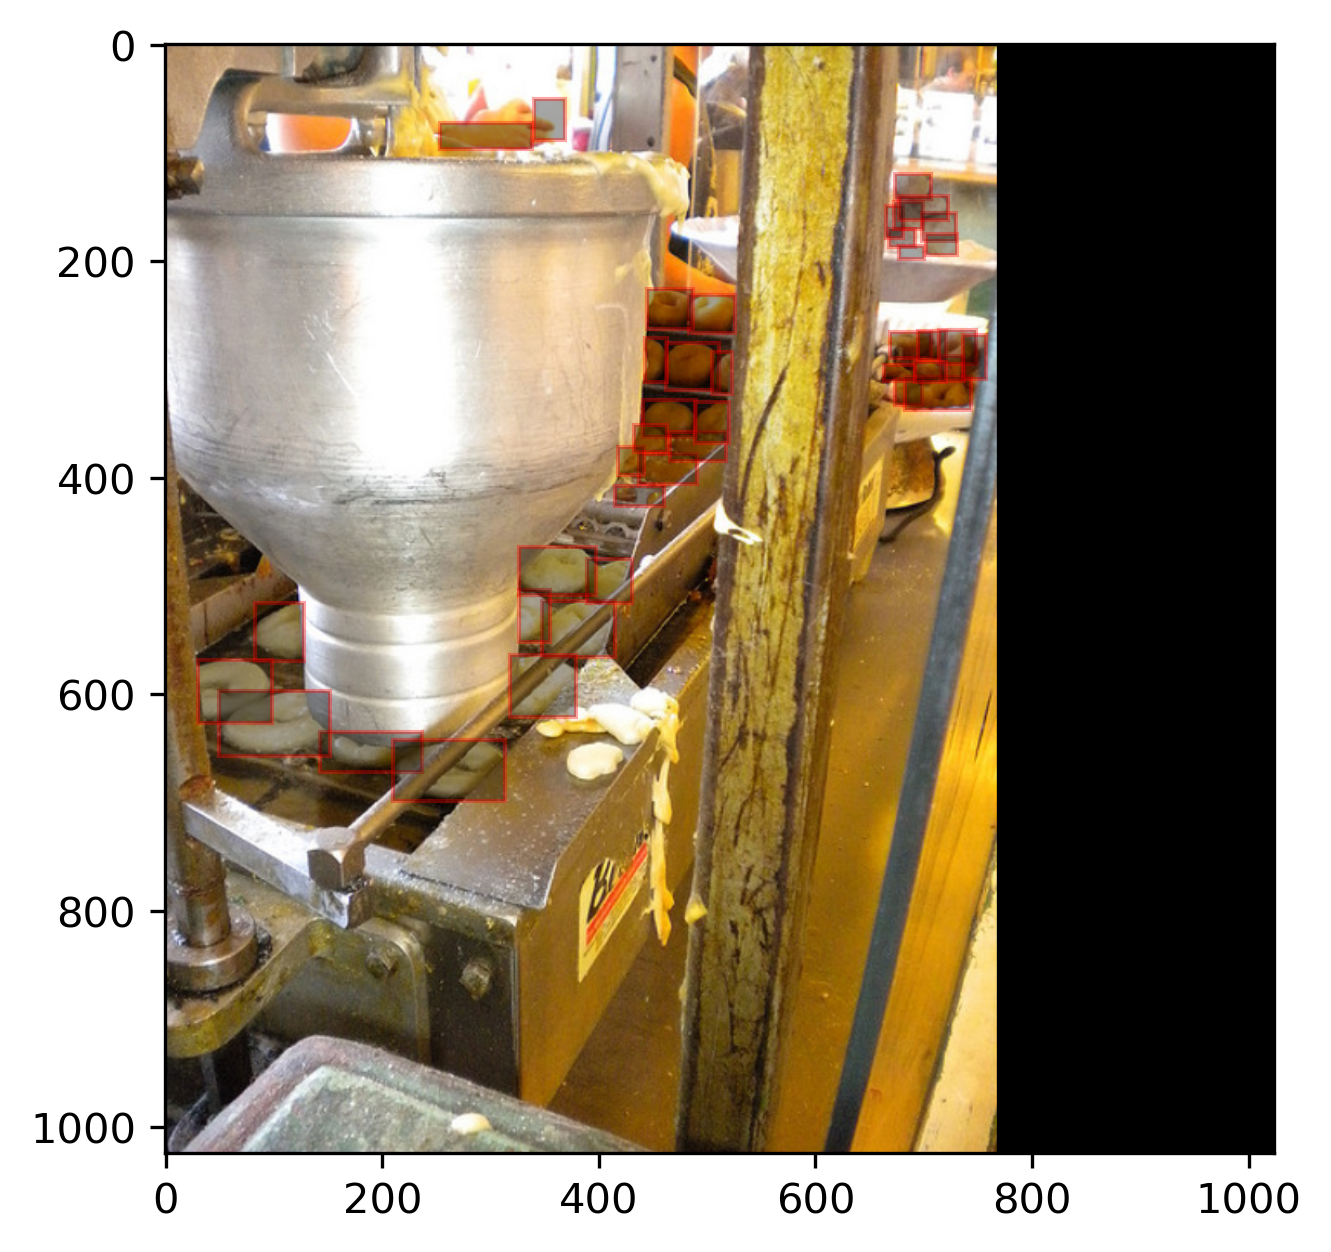

In [16]:
plot_results(read_image(fname),
             bboxes=all_data[fname]['annotations']['boxes'],
)

In [6]:
from ops.foundation_models.segment_anything.utils.amg import build_point_grid, calculate_stability_score

# points_per_side = 64
points_per_side = 32
# points_per_side = 16
grid_points = build_point_grid(points_per_side)

segment_anything_data = {}
for fname in tqdm.tqdm(all_data):
    # features = torch.load('/home/zzhuang/DATASET2/COCO/sam_vith/Org_features/' + fname, map_location='cpu').cuda()
    features = all_data[fname]['features'].cuda()
    h, w = all_data[fname]['height'], all_data[fname]['width']
    grid_points_ = grid_points.copy()
    grid_points_[:, 0] = grid_points_[:, 0] * w
    grid_points_[:, 1] = grid_points_[:, 1] * h
    # points = np.array([all_data[fname]['annotations'][l]['points'] for l in all_data[fname]['annotations']])
    # points = np.concatenate([grid_points_, points],axis=0)
    points = grid_points_
    scale = 1024 / max(h, w)
    points = points * scale
    points = torch.from_numpy(points).cuda()

    outputs = {}
    for indices in torch.arange(len(points)).split(512):
        with torch.no_grad():
            outputs_ = sam.forward_sam_with_embeddings(features, points[indices])
            
        for k in outputs_:
            if k not in outputs:
                outputs[k] = outputs_[k]
            else:
                outputs[k] = torch.cat([outputs[k], outputs_[k]], dim=0)

    pred_masks = outputs['pred_logits'].view(-1, 256, 256)
    stability_scores = calculate_stability_score(pred_masks, 0, 1.)
    pred_ious = outputs['pred_ious'].view(-1)
    pred_boxes = outputs['pred_boxes'].view(-1, 4)
    pred_masks = (pred_masks > 0.)
    indices = vision_ops.nms(pred_boxes, pred_ious, 0.7)
    mask = torch.zeros(len(pred_ious)).bool().cuda()
    mask[indices] = True
    mask = mask & (stability_scores > 0.95)
    mask = mask & (pred_ious > 0.88)
    bboxes = pred_boxes * max(h, w) / 1024
    bboxes[:, [0, 2]] = bboxes[:, [0, 2]].clamp(0, w)
    bboxes[:, [1, 3]] = bboxes[:, [1, 3]].clamp(0, h)
    box_areas = vision_ops.box_area(bboxes)
    mask = mask & ((box_areas < (h * w * 0.75)) & (box_areas > 50.))
    mask = mask & (((bboxes[:, 3] - bboxes[:, 1]) > 1.) & ((bboxes[:, 2] - bboxes[:, 0]) > 1.))
    
    pred_masks = pred_masks[mask]
    pred_boxes = pred_boxes[mask]
    pred_ious = pred_ious[mask]
    
    contour_center_points = []
    mask = torch.ones(len(pred_masks)).bool()
    for i in range(len(pred_masks)):
        m = pred_masks[i].cpu().numpy().astype(np.uint8)
        from ops.foundation_models.segment_anything.utils.amg import remove_small_regions
        # mask = remove_small_regions(mask)
        min_area = 10
        m, changed = remove_small_regions(m, min_area, mode="holes")
        unchanged = not changed
        m, changed = remove_small_regions(m, min_area, mode="islands")
        unchanged = unchanged and not changed
        m = m.astype(np.uint8)

        import imutils, cv2

        cnts = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        if len(cnts) == 0:
            mask[i] = False
            continue
        else:
            cnts = cnts[0] * 4
            M = cv2.moments(cnts)
            if M['m01'] <= 0.0001:
                mask[i] = False
                continue
            cX = int(M["m10"] / (M["m00"] + 0.0001))
            cY = int(M["m01"] / (M["m00"] + 0.0001))
            contour_center_points.append([cX, cY])
    contour_center_points = torch.Tensor(contour_center_points)
    pred_boxes = pred_boxes[mask]
    pred_ious = pred_ious[mask]
    segment_anything_data[fname] = {
        'pred_boxes': pred_boxes.cpu(),
        'pred_points': contour_center_points.cpu(),
        'pred_ious': pred_ious.cpu(),
    }

100%|███████████████████████████████████████| 2475/2475 [34:52<00:00,  1.18it/s]


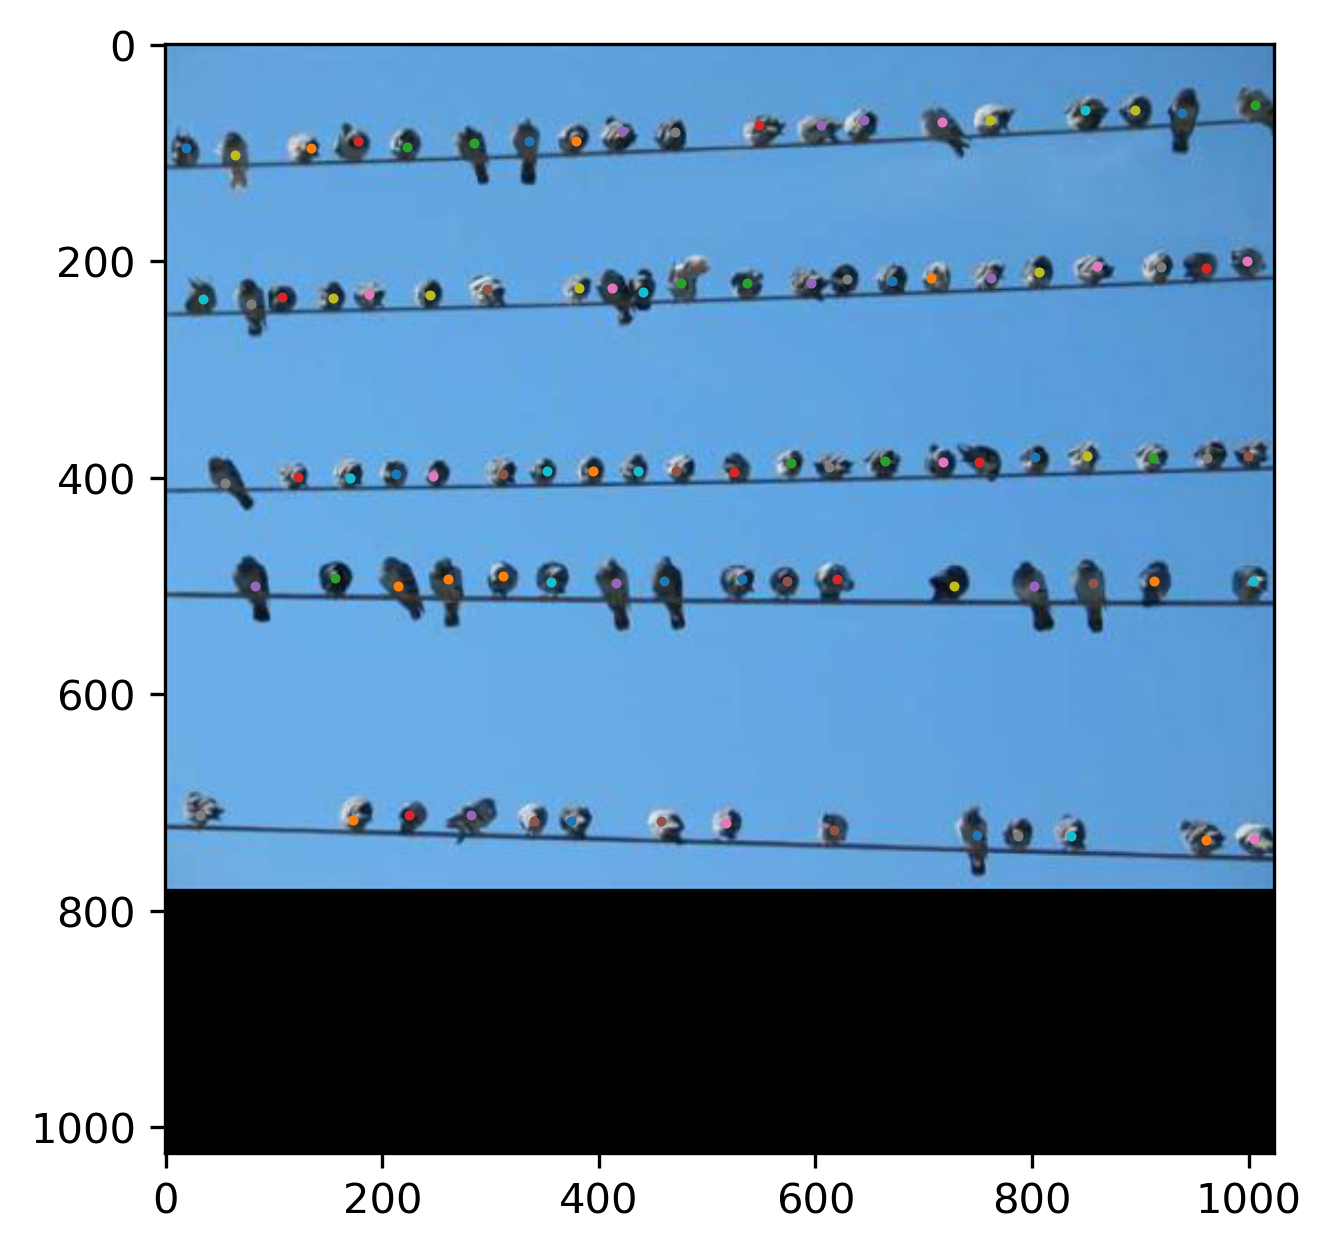

In [7]:
# read_image(fname)
fname = list(segment_anything_data)[0]
# fname = '2.jpg'
plot_results(read_image(fname),
             points=all_data[fname]['annotations']['points'],
             bboxes=segment_anything_data[fname]['pred_boxes'],
             )

In [9]:
# torch.save(segment_anything_data, '/home/zzhuang/PseCo/data/fscd_lvis/sam/segment_anything_data_vith.pth')

In [28]:
from ops.foundation_models import clip

clip.available_models()

model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)
import torchvision

normalize = torchvision.transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                                             std=(0.26862954, 0.26130258, 0.27577711))

def extract_clip_features(fname, bboxes):
    image = read_image(fname)
    examples = []
    for box in bboxes:
        example = image.crop(box.long().tolist())
        example = example.resize((224, 224))
        example = normalize(to_tensor(example)).unsqueeze(0)
        examples.append(example)
    examples = torch.cat(examples)
    e = []
    with torch.no_grad():
        for indices in torch.arange(len(examples)).split(256):
            e.append(model.encode_image(examples[indices].cuda()).float())
    e = torch.cat(e, dim=0)
    e = F.normalize(e, dim=1).cpu()
    return e

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [23]:
for split in ['train', 'test', 'val']:
    data = json.load(open(f'{project_root}/data/fscd_lvis/count_{split}.json'))
    for l in tqdm.tqdm(data['annotations']):
        boxes = torch.Tensor(l['boxes'])
        boxes = vision_ops.box_convert(boxes, 'xywh', 'xyxy')
        fname = l['file_name']
        scale = 1024 / max(all_data[fname]['height'], all_data[fname]['width'])
        boxes *= scale
        e = extract_clip_features(fname, boxes)
        all_data[fname]['example_boxes'] = boxes
        all_data[fname]['example_clip_features'] = e
    #     break
    # break

100%|████████████████████████████████████| 1181/1181 [00:00<00:00, 25994.98it/s]


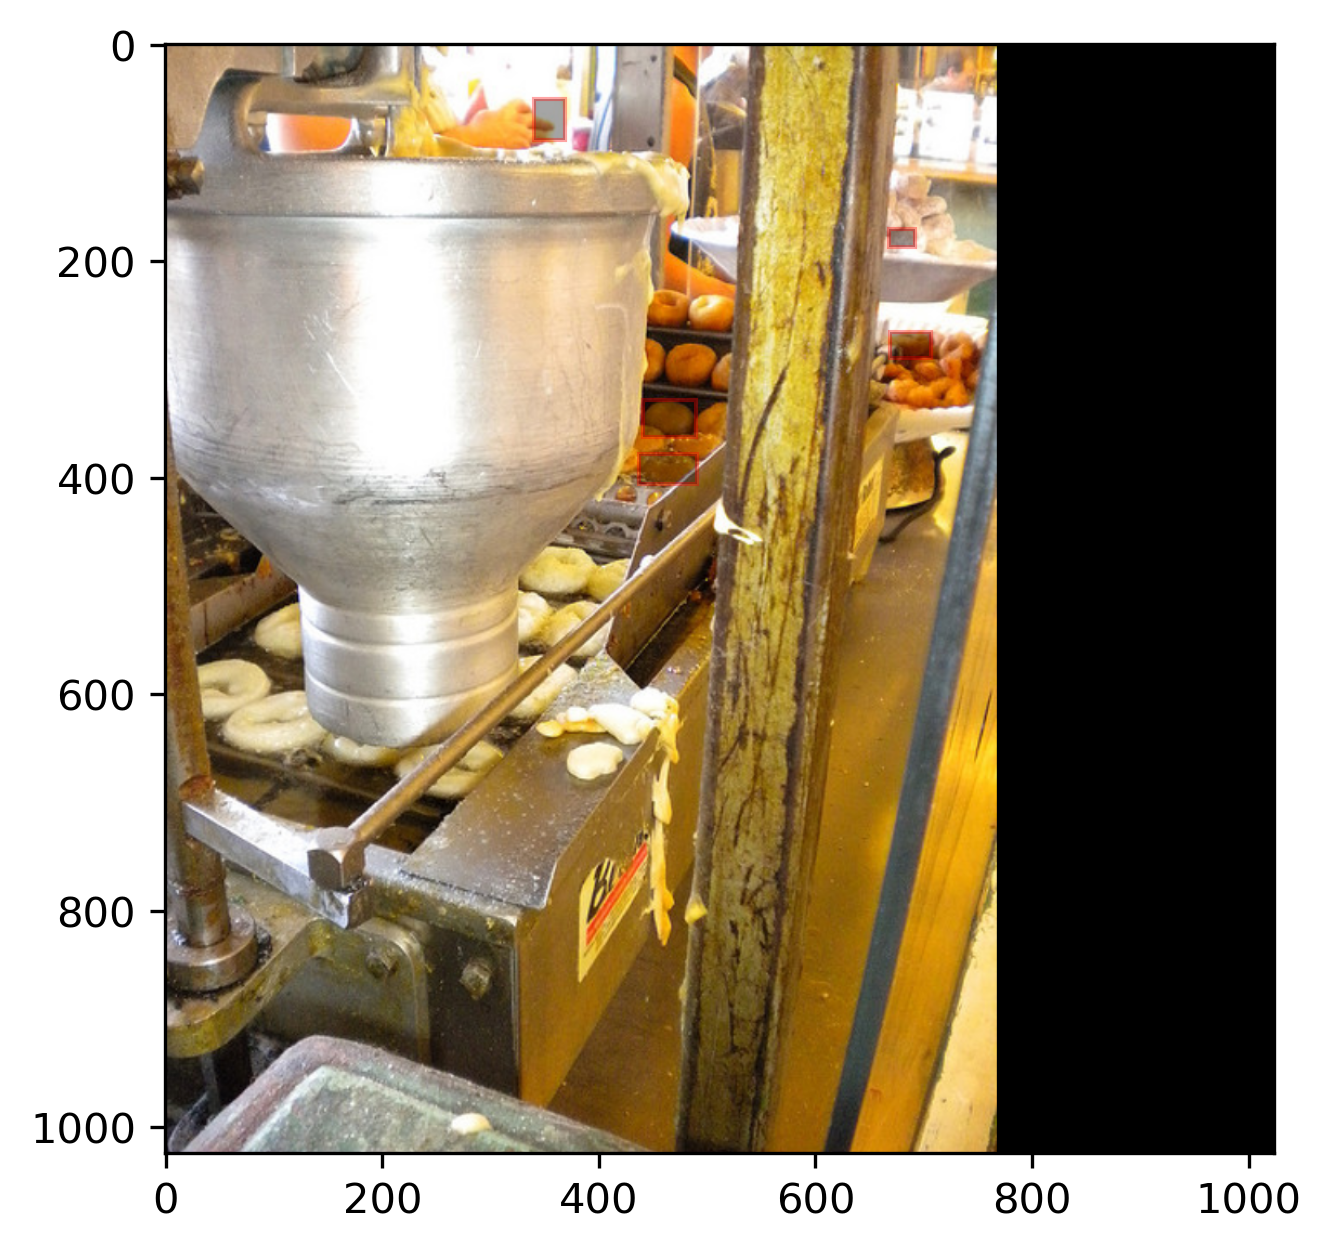

In [24]:
plot_results(read_image(fname),
             bboxes=all_data[fname]['example_boxes'])

In [26]:
all_data[fname]['example_clip_features'].mm(all_data[fname]['example_clip_features'].T)

tensor([[1.0000, 0.9421, 0.8745, 0.9252, 0.9030],
        [0.9421, 1.0000, 0.8787, 0.9503, 0.9260],
        [0.8745, 0.8787, 1.0000, 0.8868, 0.8825],
        [0.9252, 0.9503, 0.8868, 1.0000, 0.9174],
        [0.9030, 0.9260, 0.8825, 0.9174, 1.0000]])

In [29]:
#@title Define hyperparameters
FLAGS = {
    'prompt_engineering': True,
    'this_is': True,
    
    'temperature': 100.0,
    'use_softmax': False,
}
from easydict import EasyDict
FLAGS = EasyDict(FLAGS)
def article(name):
  return 'an' if name[0] in 'aeiou' else 'a'

def processed_name(name, rm_dot=False):
  # _ for lvis
  # / for obj365
  res = name.replace('_', ' ').replace('/', ' or ').lower()
  if rm_dot:
    res = res.rstrip('.')
  return res

single_template = [
    'a photo of {article} {}.'
]

multiple_templates = [
    'There is {article} {} in the scene.',
    'There is the {} in the scene.',
    'a photo of {article} {} in the scene.',
    'a photo of the {} in the scene.',
    'a photo of one {} in the scene.',


    'itap of {article} {}.',
    'itap of my {}.',  # itap: I took a picture of
    'itap of the {}.',
    'a photo of {article} {}.',
    'a photo of my {}.',
    'a photo of the {}.',
    'a photo of one {}.',
    'a photo of many {}.',

    'a good photo of {article} {}.',
    'a good photo of the {}.',
    'a bad photo of {article} {}.',
    'a bad photo of the {}.',
    'a photo of a nice {}.',
    'a photo of the nice {}.',
    'a photo of a cool {}.',
    'a photo of the cool {}.',
    'a photo of a weird {}.',
    'a photo of the weird {}.',

    'a photo of a small {}.',
    'a photo of the small {}.',
    'a photo of a large {}.',
    'a photo of the large {}.',

    'a photo of a clean {}.',
    'a photo of the clean {}.',
    'a photo of a dirty {}.',
    'a photo of the dirty {}.',

    'a bright photo of {article} {}.',
    'a bright photo of the {}.',
    'a dark photo of {article} {}.',
    'a dark photo of the {}.',

    'a photo of a hard to see {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of {article} {}.',
    'a low resolution photo of the {}.',
    'a cropped photo of {article} {}.',
    'a cropped photo of the {}.',
    'a close-up photo of {article} {}.',
    'a close-up photo of the {}.',
    'a jpeg corrupted photo of {article} {}.',
    'a jpeg corrupted photo of the {}.',
    'a blurry photo of {article} {}.',
    'a blurry photo of the {}.',
    'a pixelated photo of {article} {}.',
    'a pixelated photo of the {}.',

    'a black and white photo of the {}.',
    'a black and white photo of {article} {}.',

    'a plastic {}.',
    'the plastic {}.',

    'a toy {}.',
    'the toy {}.',
    'a plushie {}.',
    'the plushie {}.',
    'a cartoon {}.',
    'the cartoon {}.',

    'an embroidered {}.',
    'the embroidered {}.',

    'a painting of the {}.',
    'a painting of a {}.',
]
def build_text_embedding(categories):
    if FLAGS.prompt_engineering:
        templates = multiple_templates
    else:
        templates = single_template

    with torch.no_grad():
        all_text_embeddings = {}
        print('Building text embeddings...')
        for category in tqdm.tqdm(categories):
            texts = [
                template.format(processed_name(category, rm_dot=True),
                                article=article(category))
                for template in templates]
            if FLAGS.this_is:
                texts = [
                    'This is ' + text if text.startswith('a') or text.startswith('the') else text
                    for text in texts
                ]
            texts = clip.tokenize(texts)  #tokenize
            texts = texts.cuda()
            text_embeddings = model.encode_text(texts)  #embed with text encoder
            text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)
            text_embedding = text_embeddings.mean(dim=0)
            text_embedding /= text_embedding.norm()
            all_text_embeddings[category] = text_embedding.float().cpu()

    return all_text_embeddings
# text CLIP embeddings
classes = set(all_data[fname]['class_name'] for fname in all_data)
imagenet_classes = classes
print(imagenet_classes)
print(len(imagenet_classes))
zeroshot_weights = build_text_embedding(imagenet_classes)
zeroshot_weights

{'raspberry', 'ram_(animal)', 'newspaper', 'trousers', 'Lego', 'lettuce', 'tomato', 'plate', 'bowl', 'crouton', 'pot', 'bread', 'tray', 'pencil', 'strawberry', 'billboard', 'mandarin_orange', 'earphone', 'telephone', 'glove', 'trophy_cup', 'raincoat', 'drawer', 'mat_(gym_equipment)', 'helmet', 'camera', 'coat', 'shoe', 'jar', 'cassette', 'watch', 'sock', 'muffin', 'car_(automobile)', 'swimsuit', 'cock', 'gift_wrap', 'tinsel', 'gourd', 'cookie', 'pretzel', 'clip', 'icecream', 'date_(fruit)', 'lamp', 'blackberry', 'sunhat', 'cherry', 'tarp', 'egg', 'sweater', 'desk', 'turban', 'reflector', 'pie', 'parking_meter', 'umbrella', 'bell', 'scissors', 'wheel', 'bat_(animal)', 'bamboo', 'kite', 'cake', 'toothpaste', 'hook', 'chili_(vegetable)', 'celery', 'Dixie_cup', 'cone', 'folding_chair', 'salami', 'prawn', 'propeller', 'alcohol', 'cucumber', 'blazer', 'penguin', 'giant_panda', 'motorcycle', 'bench', 'awning', 'shirt', 'flag', 'plastic_bag', 'school_bus', 'backpack', 'polo_shirt', 'cupcake', 

100%|█████████████████████████████████████████| 372/372 [00:06<00:00, 60.37it/s]


{'raspberry': tensor([-2.1790e-02,  2.6360e-03, -1.0750e-02, -4.7241e-02, -2.3849e-02,
          1.2238e-02, -7.6218e-03, -8.8379e-02,  2.4147e-03, -6.1951e-03,
         -1.7227e-02, -8.9035e-03, -4.4250e-02,  1.4839e-02,  1.4313e-02,
          3.8849e-02,  1.5976e-02,  3.6255e-02,  1.5625e-02,  1.4915e-03,
          3.3234e-02,  5.1025e-02,  3.2593e-02,  3.6499e-02, -8.1444e-04,
          9.4833e-03,  1.1070e-02,  1.4091e-02, -1.1803e-02, -1.8053e-03,
         -2.2812e-02,  3.1555e-02, -3.3844e-02, -4.3526e-03,  2.4857e-02,
         -4.3335e-02, -3.2013e-02, -4.6921e-03, -2.1851e-02,  1.9028e-02,
         -2.5131e-02,  1.0872e-02,  4.0405e-02, -2.9739e-02, -1.0920e-03,
         -4.5471e-03,  2.8000e-02, -9.4604e-03, -3.5553e-02,  9.2316e-03,
          1.8600e-02, -2.3880e-02,  4.2053e-02, -1.1353e-02, -2.9716e-03,
          1.5686e-02,  4.4975e-03, -2.9388e-02, -3.5309e-02,  6.0150e-02,
          3.8544e-02, -3.9917e-02,  1.9348e-02, -1.0239e-02,  1.0292e-02,
         -3.4821e-02, -2.

In [70]:
# torch.save(zeroshot_weights, '/home/zzhuang/PseCo/data/fscd_lvis/clip_text_prompt.pth')